## LiteLLM (Proxy) + Langfuse OpenAI Integration + @observe Decorator

* [LiteLLM Proxy](https://docs.litellm.ai/docs/) ([GitHub](https://github.com/BerriAI/litellm)) which standardizes 100+ model provider APIs on the OpenAI API schema. It removes the complexity of direct API calls by centralizing interactions with these APIs through a single endpoint. You can also self-host the LiteLLM Proxy as it is open-source.

* Langfuse OpenAI SDK Wrapper (Python, JS) to natively instrument calls to all these 100+ models via the OpenAI SDK. This automatically captures token counts, latencies, streaming response times (time to first token), api errors, and more.

* Langfuse: OSS LLM Observability, full overview here.


### Step 0: Install dependencies

In [5]:
# %pip install "litellm[proxy]" langfuse openai
# 在 notebook cell 用 %pip 安装可以确保当前内核使用该环境
%pip install -U "litellm[proxy]" openai

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 0.0/812.0 kB ? eta -:--:--
     ---------------------------------------- 812.0/812.0 kB 7.0 MB/s  0:00:00
     ---------------------------------------- 0.0/9.0 MB ? eta -:--:--
     -------- ------------------------------- 1.8/9.0 MB 9.1 MB/s eta 0:00:01
     -------- ------------------------------- 1.8/9.0 MB 9.1 MB/s eta 0:00:01
     ------------------- -------------------- 4.5/9.0 MB 6.7 MB/s eta 0:00:01
     ------------------------ --------------- 5.5/9.0 MB 6.8 MB/s eta 0:00:01
     ----------------------------- ---------- 6.6/9.0 MB 6.2 MB/s eta 0:00:01
     ------------------------------- -------- 7.1/9.0 MB 6.2 MB/s eta 0:00:01
     ---------------------------------------- 9.0/9.0 MB 6.1 MB/s  0:00:01
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements t

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
crewai 0.157.0 requires litellm==1.74.9, but you have litellm 1.76.1 which is incompatible.
langfuse-haystack 2.2.0 requires langfuse<3.0.0,>=2.9.0, but you have langfuse 3.2.8 which is incompatible.


### Step 1: Setup environment

In [16]:
import os
 
# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-b26f6b38-1d21-4efb-b0ed-5057200b2148" 
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-842c4b9d-4e56-4325-9df5-5a09408f42b1" 

LANGFUSE_HOST="http://localhost:3000"

# Your openai key
# https://api.siliconflow.cn
# os.environ["OPENAI_API_KEY"] = "sk-nfyvlkiykssllzekmddumkfxggollxgwiteckpcqaxchtgty"
os.environ["OPENAI_API_KEY"] = "73c80b33ad68446ea3f059efe5c1a65f.T2PZjYiHcT2JYx2a"
os.environ["OPENAI_BASE_URL"] = "https://open.bigmodel.cn/api/paas/v4"


✅ Option A: Use OpenAI-compatible API

In [2]:
from litellm import completion
from langfuse import observe, get_client
 
langfuse = get_client()
 
@observe()
def fn():
  # set custom langfuse trace params and generation params
  response = completion(
    model="openai/glm-4.5-flash",# 使用 openai 兼容格式
    messages=[
      {"role": "user", "content": "Hi 👋 - i'm glm"}
    ],
    metadata={
        "existing_trace_id": langfuse.get_current_trace_id(),   # set langfuse trace ID
        "parent_observation_id": langfuse.get_current_observation_id(),
    },
  )
  print(response.choices[0].message.content)

fn()

Hi there! 👋 Nice to meet you, GLM! I'm your AI assistant, ready to help with whatever you need. Whether you have questions, want to chat, or need support with a task, just let me know! 😊 How can I assist you today?


### Step 3: Setup Lite LLM Proxy

Steps

1. Create a litellm_config.yaml to configure which models are available (docs). We’ll use GLM-4.5-Flash, and GLM-4.5-AirX in this example. Make sure to replace <openai_key> with your OpenAI API key.

3. Run the following cli command to start the proxy: litellm --config litellm_config.yaml

The Lite LLM Proxy should be now running on http://0.0.0.0:4000

To verify the connection you can run litellm --test

### Step 4: Log single LLM Call via Langfuse OpenAI Wrapper

The Langfuse SDK offers a wrapper function around the OpenAI SDK, automatically logging all OpenAI calls as generations to Langfuse.

#### 1: OpenAI API

In [17]:
from langfuse.openai import openai

client = openai.OpenAI()

system_prompt = (
    "You are a very accurate calculator. You output only the result of the calculation."
)

completions = client.chat.completions.create(
    model="glm-4.5-flash",
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": "2 + 2 = "},
    ],
)

print(completions.choices[0].message.content)



4


In [18]:
# Summarize cost by model
import pandas as pd
langfuse = get_client()


trace = langfuse.api.trace.get("abd09e22789f88c9dfafd40024be01e0")
observations = trace.observations


def summarize_usage(observations):
    """Summarize usage data grouped by model."""
    usage_data = []

    for obs in observations:
        usage = obs.usage
        if usage:
            usage_data.append(
                {
                    "model": obs.model,
                    "input_tokens": usage.input,
                    "output_tokens": usage.output,
                    "total_tokens": usage.total,
                }
            )

    df = pd.DataFrame(usage_data)
    if df.empty:
        return pd.DataFrame()

    summary = df.groupby("model").sum()
    return summary


# Example usage (assuming `observations` is defined as in the provided code):
summary_df = summarize_usage(observations)
summary_df

ValidationError: 54 validation errors for ParsingModel[TraceWithFullDetails]
__root__ -> observations -> 0 -> usageDetails -> 0
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 1
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 2
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 3
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 4
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 5
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 6
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 7
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 8
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 11
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 13
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 14
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 15
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 16
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 17
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 18
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 19
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 20
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 21
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 24
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 26
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 27
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 28
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 29
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 30
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 31
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 32
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 33
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 36
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 38
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 39
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 40
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 41
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 42
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 43
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 44
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 45
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 46
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 47
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 48
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 49
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 50
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 51
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 52
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 53
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 54
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 55
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 56
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 57
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 58
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 59
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> usageDetails -> 61
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> costDetails -> 0
  none is not an allowed value (type=type_error.none.not_allowed)
__root__ -> observations -> 0 -> costDetails -> 1
  none is not an allowed value (type=type_error.none.not_allowed)

#### 2: Using LiteLLM Proxy

In [ ]:
from langfuse.openai import openai
import traceback

# Set PROXY_URL to the url of your lite_llm_proxy (by default: http://0.0.0.0:4000)
PROXY_URL = "http://127.0.0.1:4000"

system_prompt = (
    "You are a very accurate calculator. You output only the result of the calculation."
)

# Configure the OpenAI client to use the LiteLLM proxy
client = openai.OpenAI(base_url=PROXY_URL)

# -- GLM failed
# try:
#     glm_4_5_flash_completion = client.chat.completions.create(
#         model="glm-4.5-flash",  # 使用 openai 兼容格式
#         messages=[
#             {"role": "system", "content": system_prompt},
#             {"role": "user", "content": "2 + 2 = "},
#         ],
#     )
    
#     print("Response object:", type(glm_4_5_flash_completion))
#     print("Choices:", glm_4_5_flash_completion.choices)
#     if glm_4_5_flash_completion.choices:
#         print("Content:", glm_4_5_flash_completion.choices[0].message.content)
    
# except Exception as e:
#     print("ERROR:", type(e), e)
#     traceback.print_exc()

# print(glm_4_5_flash_completion.choices[0].message.content)

# glm_4_5_airx_completion = client.chat.completions.create(
#     model="glm-4.5-airx",  # 使用 openai 兼容格式
#     name="GLM-4.5-AirX",
#     messages=[
#         {"role": "system", "content": system_prompt},
#         {"role": "user", "content": "5 + 2 = "},
#     ],
# )

# print(glm_4_5_airx_completion.choices[0].message.content)

llama_completion = client.chat.completions.create(
  model="ollama/llama3",
  name="llama3", # optional name of the generation in langfuse
  messages=[
      {"role": "system", "content": system_prompt},
      {"role": "user", "content": "3 + 6 = "}],
)
print(llama_completion.choices[0].message.content)


9


: 

[trace](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces?peek=95d04979080c155d58545f63fd4571ea&timestamp=2025-09-02T10%3A28%3A20.268Z&observation=de4250831c970c19)

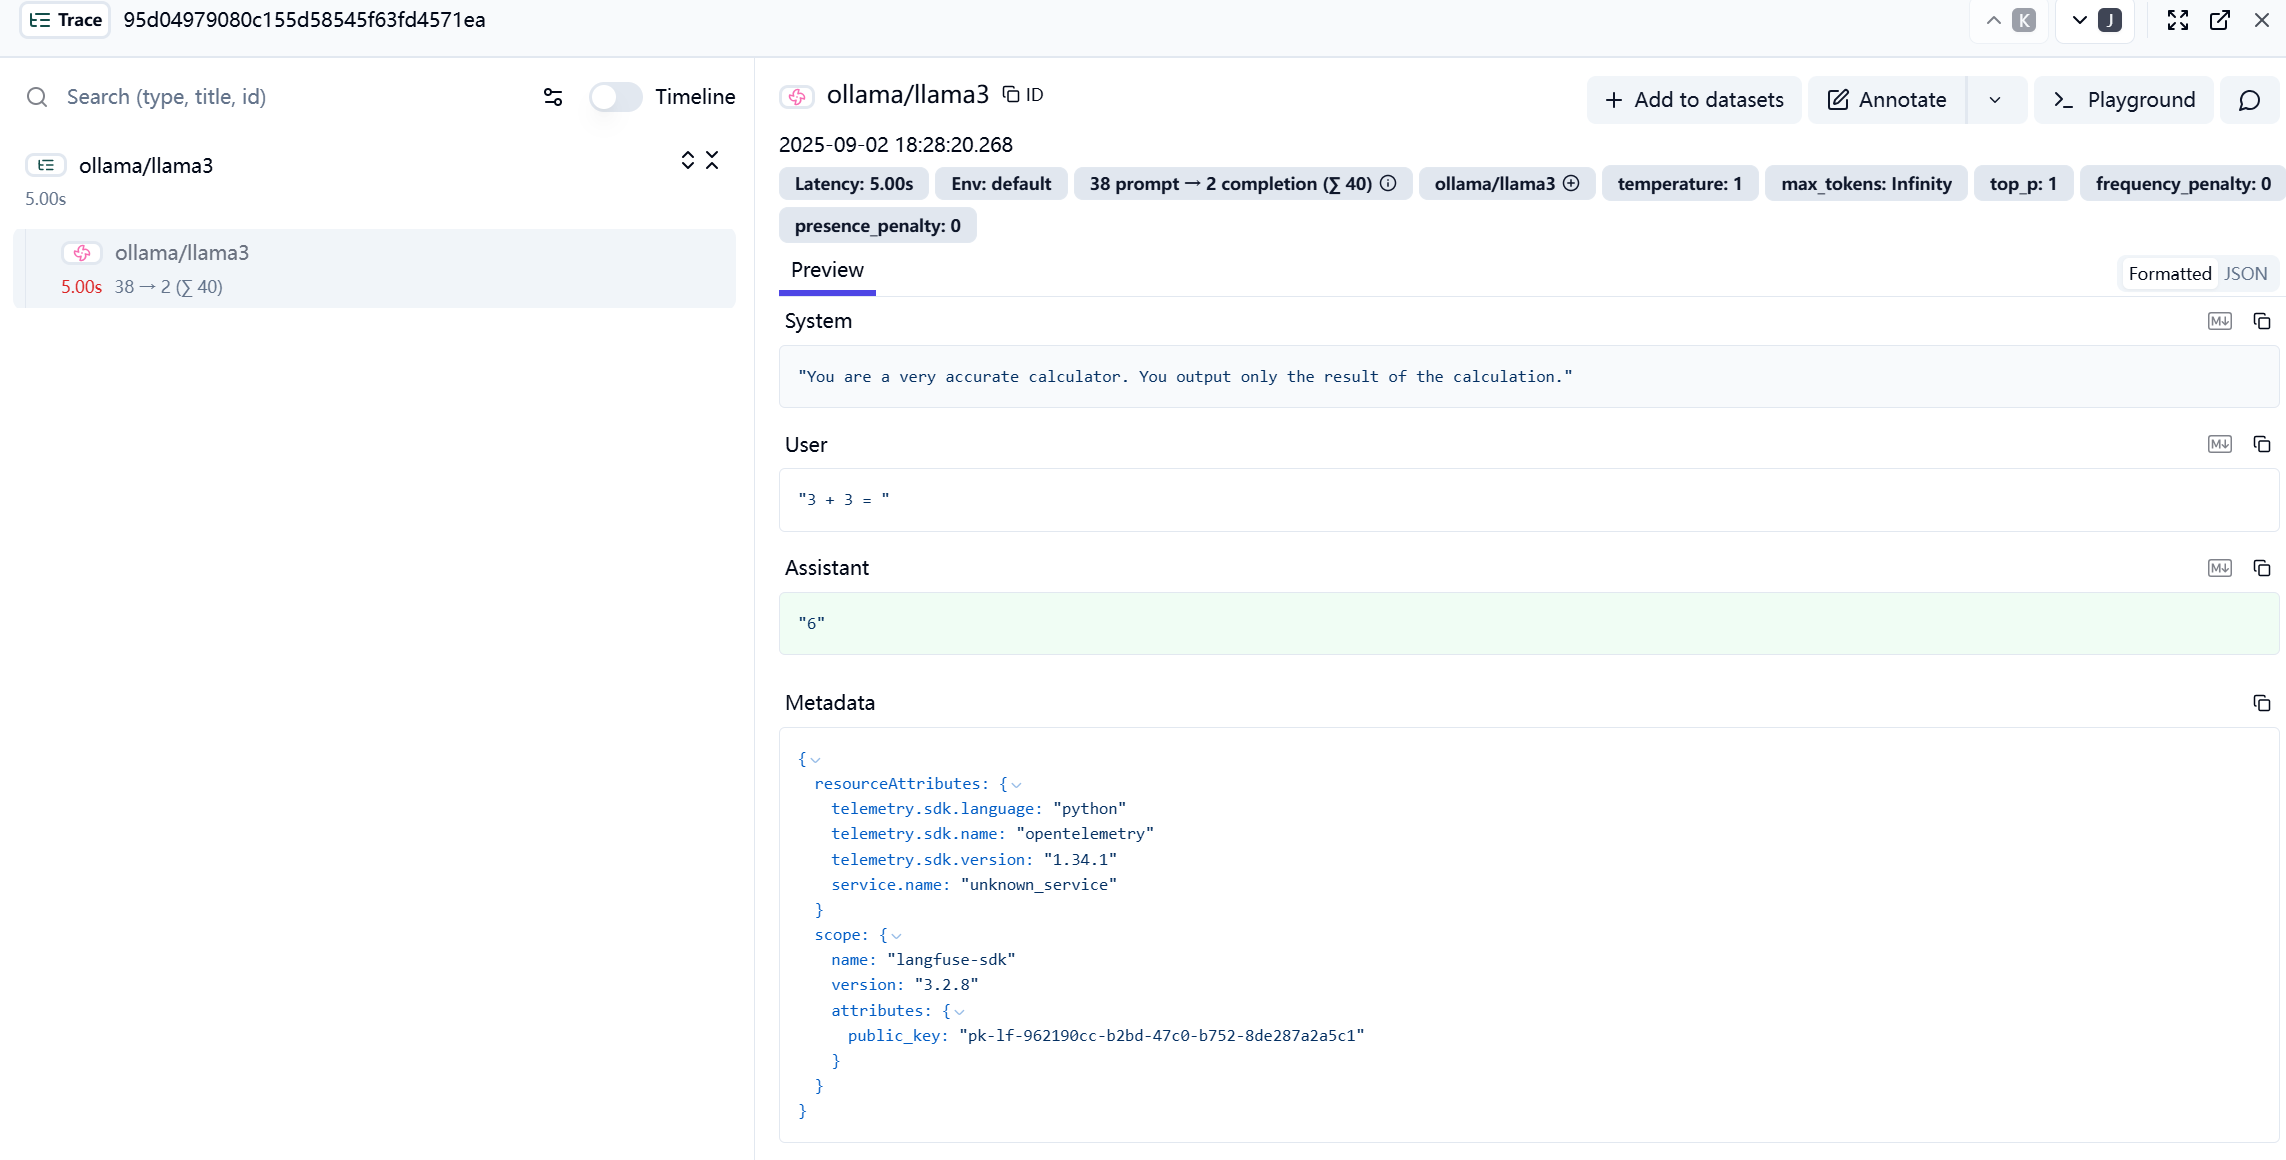